# Exploring  Building Permits Issued Data
From the date_range_for_collection.ipynb in this repository, the appropriate date ranges were selected to download [daily building permits issued](https://meck-ent-power-bi-reports-public-web.azurewebsites.net/Viewer?groupId=2ca2c01c-5658-4ee2-8a4f-5bdda8be94b7&reportId=6a4603a2-d1d1-47b7-9898-3575ed3758c6) for Mecklenburg, NC to avoid imbalanced classes (pre-COVID, COVID, COVID ignored). This notebook contains the exploration of the building permit data from August 9, 2019 to April 1, 2022. The purpose is to determine what features are included in the data, if those features values are reliable, and if there is any data that needs to be excluded from the analysis. To understand more about how the date range was selected, how the classes were decided, and how the data was retrieved and stored from the Mecklenburg County Open Data dashboard go through and review date_range_for_collection.ipynb.

In [1]:
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Loading the Data
Before the analysis can start, the data needs to be loaded. The raw data from the daily building permits issued database is too larged to be loaded into the git repository as one csv. To work around this, the below cell is the code used to split the data into multiple files which are in the git repository and used for the remaining analysis.


In [2]:
permit_raw = pd.read_csv('data/permit_issuance_raw.csv', encoding='ANSI')
filename = 'permit_issuance_raw'
split = len(permit_raw) // 3 + 1
suffix = 1
for i in range(len(permit_raw)):
    if i % split == 0:
        permit_raw[i:i+split].to_csv(f"data/{filename}_{suffix}.csv", index=False, index_label=False)
        suffix += 1

C:\Users\Ross\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (98) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Now onto the code that can be reproduced! First let's load the data, merge the data, and see the available features.

In [3]:
# Load the datasets
permit_1 = pd.read_csv('data/permit_issuance_raw_1.csv', encoding='ANSI')
permit_2 = pd.read_csv('data/permit_issuance_raw_2.csv', encoding='ANSI')
permit_3 = pd.read_csv('data/permit_issuance_raw_3.csv', encoding='ANSI')
# Merge the datasets
permit_data = [permit_1, permit_2, permit_3]
permit_df = pd.concat(permit_data)
# Get the columns of the data
print(list(permit_df.columns))
print(len(list(permit_df.columns)))

['Permit Number', 'Project Address', 'X Coord', 'Y Coord', 'Construction Cost', 'Permit Type', 'USDC Code', 'Project Number', 'Project Name', 'Owner/Tenant', 'SubTrade', 'Owner/Tenant Address', 'Owner/Tenant Phone', 'Issue Date', 'Parcel Number', 'Lot', 'Electric Utility Company', 'Electrical Service', 'Total Amps', 'Number of Circuits', 'Circuits at 120 Volts', 'Circuits over 120 Volts', 'Mechanical Utility Company', 'Number of Gas Connections', 'Number of Appliances (Mechanical)', 'Utilities', 'Public Utility Individual Meter/Connection - Sewer', 'Public Utility Individual Meter/Connection - Water', 'Public Utility Master Meter/Connection - Sewer', 'Public Utility Master Meter/Connection - Water', 'Private Utility Community - Septic', 'Private Utility Community - Well', 'Private Utility Individual - Septic', 'Private Utility Individual - Well', 'Central Air Conditioning', 'Electric Furnace', 'Gas or Oil Furnace', 'Gas or Oil Steam', 'Gas Pack', 'Heat Pump', 'Prefabricated Fireplace',

## Selecting features.
There are a lot of features (112) but most are not important or useful for the type of analysis ahead. Some features will be removed before moving on to further exploration. For example fax number, contractor information, appliance types, and if it is a corner lot can be left behind. For analysis on a city level tax jurisdiction would be useful, but this analysis will occur on the county level. Ultimately, 13 features are worth exploring further.

In [4]:
permit_df = permit_df[['Permit Number', 'Permit Type', 'Construction Cost', 'Project Name', 'Owner/Tenant',
                       'Issue Date', 'Occupancy', 'Number of Stories', 'Total Fee', 'Building Contract Cost',
                       'Number of Units', 'Description of Work']]
permit_df.head()

,Permit Number,Permit Type,Construction Cost,Project Name,Owner/Tenant,Issue Date,Occupancy,Number of Stories,Total Fee,Building Contract Cost,Number of Units,Description of Work
0,B3726808,One/Two Family,62100.0,Zusi - Deck upfit Repair/Replace.,Jeffrey & Kimberly Zusi,3/26/2020 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,704.0,"$61,000.",1.0,Zusi - Deck upfit
1,B3821699,One/Two Family,20200.0,Zuriyah Clary Repair/Replace. Foundation Work.,Zuriyah Clary,9/8/2020 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,279.0,"$20,200.",1.0,Zuriyah Clary
2,B3715083,Commercial,168000.0,ZURICH,THE KEITH CORP,3/6/2020 12:00:00 PM,B * BUSINESS,0.0,1286.0,"$114,700.",1.0,NaN
3,B3933094,One/Two Family,27000.0,ZUPPO / LAUNDRY ADD / PLAN REV,DAVID ZUPPO,12/20/2021 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,240.0,"$22,000.",1.0,Laundry Room Addition
4,B4153710,One/Two Family,19700.0,Zuilkowski Deck Addition Addition (expand foot...,NANCY ZUILKOWSKI,2/24/2022 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,332.0,"$19,700.",1.0,Zuilkowski Deck Addition


In [5]:
# Let's see the number of observations in the dataset
print(permit_df.shape)

(65195, 12)


## What types of permits should stay in the data?
First, it is important to see what different types of occupancy can exist in the building permits data. The focus of this project is building permits for housing, so a permit to build something that will not house people should not be included.

In [6]:
permit_df['Occ_Code'] = permit_df['Occupancy'].str[:2]
permit_df['Occupancy'].unique()

array(['R3     * RESIDENTIAL - SINGLE FAMILY', 'B      * BUSINESS',
       'R2     * RESIDENTIAL - MULTIPLE FAMILY',
       'S1     * STORAGE - MODERATE HAZARD',
       'F1     * FACTORY/INDUSTRIAL - MODERATE HAZARD',
       'S2     * STORAGE - LOW HAZARD',
       'A2     * ASSEMBLY - RESTAURANTS, BARS, BANQUET HALLS',
       'M      * MERCANTILE', 'U      * UTILITY',
       'A4    *ASSEMBLY - ARENA, SKATING RINK, TENNIS CT',
       'A3HLM     * ASSEMBLY - HALL/LIBRARY/MUSEUM',
       'A3C     * ASSEMBLY - COMMON ASSEMBLIES',
       'A2     * ASSEMBLY - RESTAURANTS, NIGHTCLUBS, BARS, BANQUET HALLS',
       'R1     * RESIDENTIAL - HOTELS',
       'A5    *ASSEMBLY - OUTDOOR STADIUM, BLEACHER, GRANDSTAND',
       'I2H     * INSTITUTIONAL - INCAPACITATED - HOSPITAL, LIMITED NURSING & MEDICAL TREATMENT',
       'E      * EDUCATIONAL', 'A1     * ASSEMBLY - THEATER w/o STAGE',
       nan, 'A4    *ASSEMBLY - INDOOR ARENA, SKATING RINK, TENNIS COURT',
       'A3C     * ASSEMBLY - CHURCH',
     

Most of the permit types aren't for housing! The only ones that are are the residential ones (R1, R2, R3, R4), excluding hotels. Before removing the other occupancy types from the data, it would be good to see how building permit issuance is distributed amongst the various types.

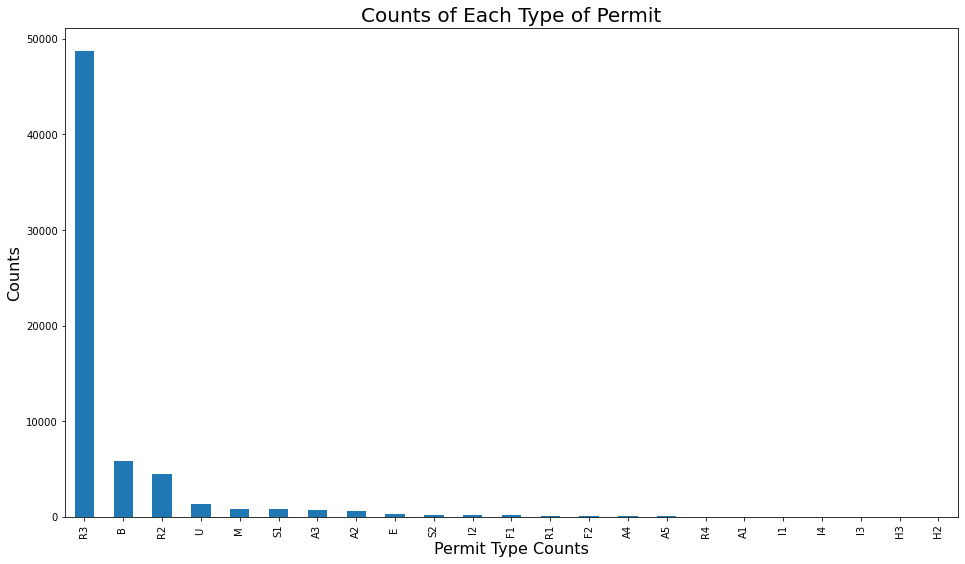

In [7]:
fig, ax = plt.subplots(figsize=(16,9))
permit_df['Occ_Code'].value_counts().plot(kind='bar')
ax.set_ylabel('Counts', fontsize=16)
ax.set_xlabel('Permit Type Counts', fontsize=16)
plt.title('Counts of Each Type of Permit', fontsize=20)
plt.savefig('visualizations/counts_permit_type.jpeg')

Almost 50,000 of permits are for single family residences. Multiple family residences are also the third most common type of building permit issued as well, so most of the 65,195 observations should remain.

In [8]:
# Filter the data to only keep R2, R3, and R4 Occupancies
permit_df = permit_df.drop('Occ_Code', axis=1)
permit_df = permit_df[permit_df.Occupancy.str[0:2].isin(['R2', 'R3', 'R4'])]
permit_df.shape

(53240, 12)

## How should the quantity of housing built be determined?
The next step is to decide how to quantify the amount of housing that is being approved by the county. There are two different ways to do so; count the number of rows or sum the Number of Units column. To decide which approach is more accurate it's important to understand what the Number of Units column is stating. There is no data dictionary provided, so exploring individual cases will be the approach used. To do this the data will be filtered to the Owner/Tenant with the most rows available of non-R3 Occupancy and explore the data. This approach is taken because the Owner/Tenant with the most rows are probably building structures with multiple residential units, and it will be easier to see how this feature operates in an individual case.

R3 is filtered out as well, because it should be one or two units for each permit. Before going forward with the non-R3 analysis it's important to see if what is expected of R3 data is true.

In [9]:
single_fam_df = permit_df[permit_df['Occupancy'].str.contains('R3') == True]
single_fam_df.sort_values('Number of Units', ascending=False)

,Permit Number,Permit Type,Construction Cost,Project Name,Owner/Tenant,Issue Date,Occupancy,Number of Stories,Total Fee,Building Contract Cost,Number of Units,Description of Work
10255,B4085729,One/Two Family,4500.0,Lot 10 Demolish/Move Off. SF Dwelling Detached.,JMR PROPERTIES,11/12/2021 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,486.0,"$4,500.",1500.0,Lot 10
9946,B4070149,One/Two Family,219872.0,SOUTH CREEK CONSTRUCTION / NEW RES / PLAN REVIEW,Southcreek Construction,10/14/2021 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,2.0,1656.0,"$125,000.",1453.0,BF052
5257,B3661645,One/Two Family,360000.0,CHARLOTTE CUSTOM/NEW RES/PLAN REV,JOHN MARUCCI,1/7/2020 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,2.0,2014.0,"$325,000.",1324.0,3201 Johnny Cake Ln.
12950,B3682711,One/Two Family,145000.0,KELLY MCARDLE/ATT.GARAGE & PORCH/PLAN REV,Jeff & Heather Dickey,3/6/2020 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,2.0,1259.0,"$130,000.",1004.0,KellyMcArdle Dickey Garage/Porch
1202,B3671766,One/Two Family,249462.0,WBT 19 New Single Family Residence New. SF Dwe...,"Lennar Carolinas, LLC",12/18/2019 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,2.0,1691.0,"$158,000.",738.0,WBT 19 New Single Family Residence
...,...,...,...,...,...,...,...,...,...,...,...,...
15586,B4076465,One/Two Family,75000.0,In ground pool 12x28 Pool apron 110 sq ft New....,Grandfather Homes- Colon,10/19/2021 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,835.0,"$73,000.",0.0,In ground pool 12x28 Pool apron 110 sq ft
1463,B3838246,One/Two Family,28000.0,WALSH/RM ADDITION/PLAN REV,Joe walsh,10/29/2020 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,454.0,"$25,000.",0.0,rear addition
21660,B4082232,One/Two Family,9900.0,demolition of dwelling Demolish/Move Off. SF D...,Atrium Health - Austin Baizer,10/27/2021 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,486.0,"$9,900.",0.0,demolition of dwelling
1439,B3874141,One/Two Family,3500.0,PARTY ONE New. Deck.,COREY N JOHNSON/KIRON C JOHNSON,12/9/2020 12:00:00 PM,R3 * RESIDENTIAL - SINGLE FAMILY,0.0,162.0,"$3,500.",0.0,PARTY ONE


<AxesSubplot:>

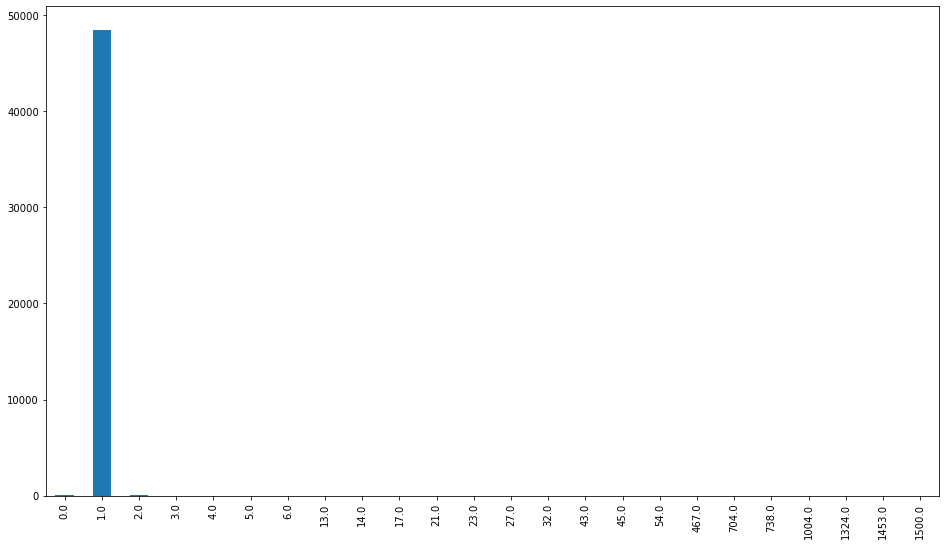

In [10]:
single_fam_df['Number of Units'].value_counts().sort_index().plot(kind='bar', figsize=(16,9))

While the above does show outliers, the vast majority have 1 Unit of housing.

Now to explore the Owners/Tenants of non-R3 residentials.

In [11]:
multi_res_df = permit_df[permit_df['Occupancy'].str.contains('R3') == False]
multi_res_df.groupby(['Owner/Tenant']).size().sort_values()

Owner/Tenant
115 E park ave HOA                    1
Magnolia Place HOA                    1
Maple Multi-Family Land  SE L.P.      1
Marc and Denise Hayes                 1
Mark & Amy Ryan                       1
                                   ... 
HORIZON DEVELOPMENT PROPERTIES       61
ACTS                                 70
Heritage Park Housing Partners       74
SDC COLONY RETAIL, LLC               78
BRIET MF Beacon Hill LLC            377
Length: 976, dtype: int64

BRIET MF Beacon Hill LLC has the most number of rows. Next, to see what their data looks like.

In [12]:
briet_df = multi_res_df[multi_res_df['Owner/Tenant'] == 'BRIET MF Beacon Hill LLC']
print(briet_df['Number of Units'].unique())
print(briet_df['Occupancy'].unique())
briet_df.head(10)

[0. 1.]
['R2     * RESIDENTIAL - MULTIPLE FAMILY']


,Permit Number,Permit Type,Construction Cost,Project Name,Owner/Tenant,Issue Date,Occupancy,Number of Stories,Total Fee,Building Contract Cost,Number of Units,Description of Work
11819,B3869310,Commercial,1316.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,3/2/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,119.0,$450.,0.0,Beacon Hill Apartments- Washer/Dryer Connections
11820,B3912057,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11821,B3912058,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11822,B3912059,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11823,B3912060,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11824,B3912061,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11825,B3912062,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11826,B3912063,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11827,B3912064,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN
11828,B3912065,Commercial,3866.0,SM COMM EPS - Beacon Hill Apts- add of Washer/...,BRIET MF Beacon Hill LLC,2/10/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$700.,1.0,NaN


<AxesSubplot:>

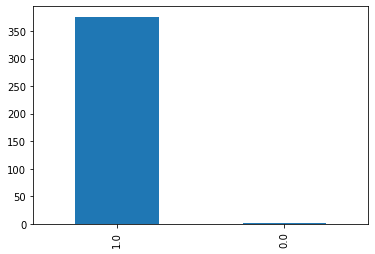

In [13]:
briet_df['Number of Units'].value_counts().plot(kind='bar')

The multiple family permits for BRIET show us a similar story to what was expected for R3 permits; the vast number of entries are 1 unit. The outlier values when looking at all R3 data are at least gone in this example which is expected, but what about the other types of residential permits? Are there permits of over 1 unit which are valid? This experiment will go one more time for the non-R3 Owner/Tenant which has the most rows of Units greater than 1.

In [14]:
multi_unit_df = multi_res_df[multi_res_df['Number of Units'] > 1]
multi_unit_df.groupby(['Owner/Tenant']).size().sort_values()

Owner/Tenant
130 CHEROKEE LLC                               1
MAYFIELD APARTMENTS, LLC                       1
MARSH REALTY CO                                1
Lat Perser & Associates Inc                    1
Jason McArthur                                 1
                                              ..
Abberly Liberty Crossing, LLC                 33
4929 TUCKASEEGEE LLC                          36
Spire Apartments LP                           36
Chad Hagler                                   42
Charlotte NC Heritage Properties I K6, LLC    43
Length: 181, dtype: int64

Now to repeat the previous work with Charlotte NC Heritage Properties I K6, LLC.

In [15]:
char_df = multi_unit_df[multi_unit_df['Owner/Tenant'] == 'Charlotte NC Heritage Properties I K6, LLC']
print(char_df['Number of Units'].unique())
print(char_df['Occupancy'].unique())
char_df

[4. 6. 2. 3.]
['R2     * RESIDENTIAL - MULTIPLE FAMILY']


,Permit Number,Permit Type,Construction Cost,Project Name,Owner/Tenant,Issue Date,Occupancy,Number of Stories,Total Fee,Building Contract Cost,Number of Units,Description of Work
10757,B3926217,Commercial,644226.0,AHP Heritage/ UNCC - Building 9,"Charlotte NC Heritage Properties I K6, LLC",3/26/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3657.0,"$498,564.",4.0,NaN
10758,B3949295,Commercial,644224.0,AHP Heritage/ UNCC - Building 8,"Charlotte NC Heritage Properties I K6, LLC",4/27/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3657.0,"$498,562.",4.0,NaN
10759,B3949287,Commercial,644224.0,AHP Heritage/ UNCC - Building 7,"Charlotte NC Heritage Properties I K6, LLC",4/27/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3657.0,"$498,562.",4.0,NaN
10760,B3949281,Commercial,644224.0,AHP Heritage/ UNCC - Building 6,"Charlotte NC Heritage Properties I K6, LLC",4/27/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3657.0,"$498,562.",4.0,NaN
10761,B3917018,Commercial,644224.0,AHP Heritage/ UNCC - Building 5,"Charlotte NC Heritage Properties I K6, LLC",2/17/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3657.0,"$498,562.",4.0,NaN
10762,B3917016,Commercial,644224.0,AHP Heritage/ UNCC - Building 4,"Charlotte NC Heritage Properties I K6, LLC",2/17/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3657.0,"$498,562.",4.0,NaN
10764,B3926430,Commercial,4.0,AHP Heritage/ UNCC - Building 33 - Floor 3,"Charlotte NC Heritage Properties I K6, LLC",3/26/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,6.0,NaN
10765,B3926428,Commercial,4.0,AHP Heritage/ UNCC - Building 33 - Floor 2,"Charlotte NC Heritage Properties I K6, LLC",3/26/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,6.0,NaN
10766,B3926425,Commercial,4.0,AHP Heritage/ UNCC - Building 33 - Floor 1,"Charlotte NC Heritage Properties I K6, LLC",3/26/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,6.0,NaN
10767,B3917020,Commercial,644224.0,AHP Heritage/ UNCC - Building 32,"Charlotte NC Heritage Properties I K6, LLC",2/17/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3667.0,"$498,562.",4.0,NaN


This data appears to represent the number of separate housing units per building in the Number of Units parameter. Charlotte NC Heritage Properties I K6, LLC is [developing student housing](https://www.bizjournals.com/charlotte/news/2021/01/13/co-living-university-city-aspen-heights.html?b=1610538260%5E21842637) and the structures appear to contain multiple units. However, this is not conclusive in saying Number of Units is a reliable feature, so Chad Hagler's (the Owner/Tenant second on the list) data will also be reviewed. 

In [16]:
chad_df = multi_unit_df[multi_unit_df['Owner/Tenant'] == 'Chad Hagler']
print(chad_df['Number of Units'].unique())
print(chad_df['Occupancy'].unique())
chad_df

[ 2. 20. 10. 12.  8.  4. 18.  9. 22.  6.]
['R2     * RESIDENTIAL - MULTIPLE FAMILY']


,Permit Number,Permit Type,Construction Cost,Project Name,Owner/Tenant,Issue Date,Occupancy,Number of Stories,Total Fee,Building Contract Cost,Number of Units,Description of Work
295,B4066167,Commercial,668110.0,WOODFIELD - LAKESIDE - Building 9,Chad Hagler,10/20/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,2.0,3788.0,"$582,330.",2.0,NaN
297,B4066467,Commercial,4.0,WOODFIELD - LAKESIDE - Building 7 Level 3,Chad Hagler,10/20/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN
298,B4066465,Commercial,4.0,WOODFIELD - LAKESIDE - Building 7 Level 2,Chad Hagler,10/20/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN
299,B4066460,Commercial,4.0,WOODFIELD - LAKESIDE - Building 7 Level 1,Chad Hagler,10/20/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN
300,B4066459,Commercial,4.0,WOODFIELD - LAKESIDE - Building 7 Ground Level,Chad Hagler,10/20/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,10.0,NaN
302,B4063580,Commercial,4.0,WOODFIELD - LAKESIDE - Building 6 Level 3,Chad Hagler,10/6/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN
303,B4063577,Commercial,4.0,WOODFIELD - LAKESIDE - Building 6 Level 2,Chad Hagler,10/6/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN
304,B4063573,Commercial,4.0,WOODFIELD - LAKESIDE - Building 6 Level 1,Chad Hagler,10/6/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN
305,B4063570,Commercial,4.0,WOODFIELD - LAKESIDE - Building 6 Ground Level,Chad Hagler,10/6/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,10.0,NaN
307,B4063568,Commercial,4.0,WOODFIELD - LAKESIDE - Building 5 Level 3,Chad Hagler,10/6/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,1.0,239.0,$1.,20.0,NaN


The numbers look large, but according to Woodfield's website the [Lakeside](https://woodfielddevelopment.net/communities/lakeside/) community will contain 332 and the [Farmington](https://woodfielddevelopment.net/communities/farmington/) community will contain 275 units. Below tests to see if the sum total of Number of Units match the Woodfield website.

In [17]:
print('The number of Farmington units are:',
      chad_df['Number of Units'].loc[chad_df['Project Name'].str.contains('FARMINGTON')].sum())
print('The number of Lakeside units are:',
      chad_df['Number of Units'].loc[chad_df['Project Name'].str.contains('LAKESIDE')].sum())

The number of Farmington units are: 275.0
The number of Lakeside units are: 272.0


The Farmington total matches the Woodfield website, while the Lakeside total is 50 units less than what Woodfield is claiming. This could be due to some of the units not being residential, but it appears that summing the Number of Units is a more accurate indicator of housing being built than counting the rows.

## What about the outliers?
Earlier, when reviewing the Number of Units feature for R3 permits, there were a few outliers that would skew the results when summing Number of Units. Detecting R3 outliers and correcting the data is easy enough; whenever there is a value greater than 2 set it equal to 1 instead. Detecting and solving outliers for non-R3 permits is more difficult though because, as seen earlier, these structures can have more than 2 units of housing. The first step is to see the distribution of Number of Units feature in non-R3 data and if any obvious outliers appear.

<AxesSubplot:>

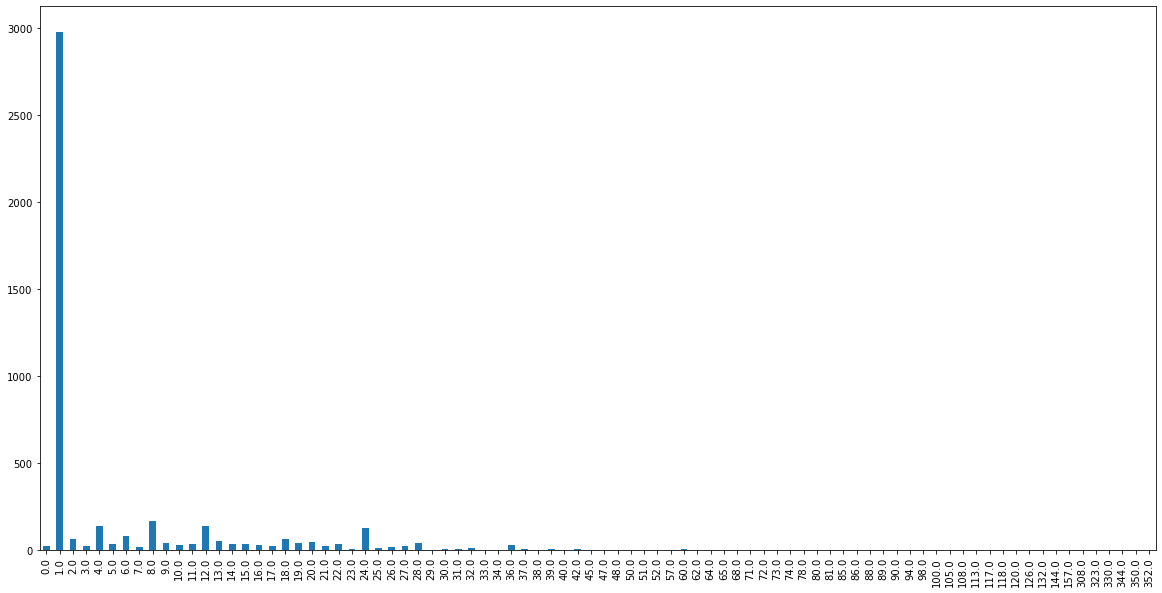

In [18]:
multi_res_df['Number of Units'].value_counts().sort_index().plot(kind='bar', figsize=(20,10))

These structures can be large multifamily residential buildings, so the large values do not automatically mean they are incorrect figures. However, they do need to be examined.

In [19]:
multi_res_df[multi_res_df['Number of Units']>49].sort_values('Number of Units', ascending=False).head(10)

,Permit Number,Permit Type,Construction Cost,Project Name,Owner/Tenant,Issue Date,Occupancy,Number of Stories,Total Fee,Building Contract Cost,Number of Units,Description of Work
11055,B4036537,Commercial,1002.0,SM COMM EPS MMF Alta Filament - Tower Crane,Alta Filament LLC,8/30/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,239.0,$1.,352.0,Alta Filament - Tower Crane
13869,B4008904,Commercial,24995.0,SHOPTON ROAD APARTMENTS,RANGE WATER REAL ESTATE,7/1/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,328.0,$1.,350.0,NaN
6675,B3719460,Commercial,2820900.0,MMF Novel LoSo Station FT/FD,Crescent Acquistiions,3/13/2020 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,6.0,10017.0,"$2,498,900.",344.0,NaN
9914,B3785297,Commercial,5000.0,Magnolia gardens demo,Magnolia Gardens Housing LLC,7/9/2020 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,3.0,84.0,"$5,000.",330.0,Magnolia gardens demo
6157,B4046623,Commercial,2730000.0,MMF Broadstone Optimist Park-Phase2 Type 1A Un...,Chad Platt,9/22/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,6.0,8212.0,"$1,501,500.",323.0,NaN
6229,B4089137,Commercial,160700.0,MMF Alta West Morehead Shoring Wall,Wood Partners,11/4/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,1254.0,"$160,700.",308.0,Alta West Morehead
10530,B4109412,Commercial,1100.0,ALTA WEST MOREHEAD,"Alta West Morehead Owner, LLC.",12/9/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,0.0,119.0,$100.,308.0,Alta West Morehead
9369,B4137472,Commercial,10770301.0,SPT 10.30.20 Indigo Apartments - Shell,"INDIGO CLT, LLC",1/31/2022 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,5.0,30256.0,"$9,291,100.",157.0,NaN
8714,B4011567,Commercial,20553149.0,SPT AHP 6.9.20 Dillehay Court Apartments,HORIZON DEVELOPMENT PROPERTIES,7/7/2021 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,4.0,45253.0,"$20,518,700.",144.0,NaN
8842,B4136539,Commercial,17160601.0,SPT 9.8.21 AH Eastway Crossings,Eastway Harmony Housing LLC,2/3/2022 12:00:00 PM,R2 * RESIDENTIAL - MULTIPLE FAMILY,4.0,40672.0,"$13,860,000.",132.0,NaN


Looking at the top result, [Alta Filament apartments](https://www.prnewswire.com/news-releases/wood-partners-breaks-ground-on-latest-luxury-apartment-community-in-charlotte-301395245.html), it appears the large number is due to reporting the total number of units differently than Heritage Properties and Chad Hagler. Instead of reporting each structure separately, Filament reported all total units at once. These do not appear to be outliers, and their values will remain.

The R3 Number of Units data does still need to be cleaned though, and is be below.

In [20]:
df_final = permit_df
df_final["Number of Units"] = np.where((df_final['Occupancy'].str.contains('R3') == True) & (df_final['Number of Units'] > 2),
                                       1, df_final['Number of Units'])

This df is saved in the data folder for the analysis section of this project.

In [21]:
df_final.to_csv('data/cleaned_data.csv')